In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/Alcohol_Sales.csv')
df['Month']= pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
#df.index.freq='MS'

In [3]:
df = df[-48:]
df.head()

,Sales
Month,
2015-01-02,9062
2015-01-03,10722
2015-01-04,11107
2015-01-05,11508
2015-01-06,12904


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2015-01-02 to 2019-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   48 non-null     int64
dtypes: int64(1)
memory usage: 768.0 bytes


<AxesSubplot:xlabel='Month'>

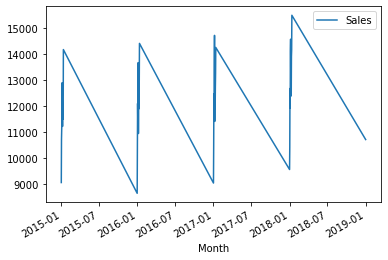

In [5]:
df.plot()

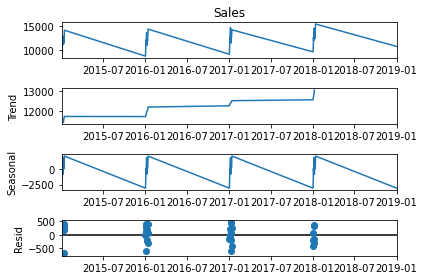

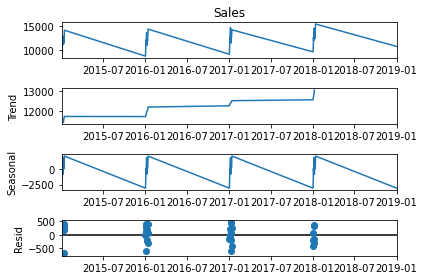

In [6]:
results = seasonal_decompose(df['Sales'], freq=12)
results.plot()

In [7]:
len(df)

48

In [8]:
train = df.iloc[:36]
test = df.iloc[36:]

scaler = MinMaxScaler()

In [9]:
df.head(), df.tail()

(            Sales
 Month            
 2015-01-02   9062
 2015-01-03  10722
 2015-01-04  11107
 2015-01-05  11508
 2015-01-06  12904,
             Sales
 Month            
 2018-01-09  12396
 2018-01-10  13914
 2018-01-11  14174
 2018-01-12  15504
 2019-01-01  10718)

In [10]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.06806971],
       [0.34100625],
       [0.40430779],
       [0.47024005],
       [0.69976981],
       [0.52959553],
       [0.42354489],
       [0.55475173],
       [0.54833936],
       [0.46991121]])

# Recursive Strategy

In [13]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.06806971],
         [0.34100625],
         [0.40430779],
         [0.47024005],
         [0.69976981],
         [0.52959553],
         [0.42354489],
         [0.55475173],
         [0.54833936],
         [0.46991121],
         [0.91006248],
         [0.        ]]]),
 array([[0.27507399]]))

In [14]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(generator, epochs=50, verbose=0)

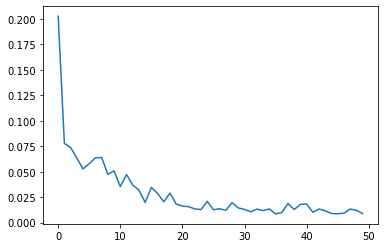

In [16]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [17]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.42060077]], dtype=float32)

In [18]:
scaled_test[0], scaled_test[1]

(array([0.29052943]), array([0.66343308]))

In [19]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.42060077], dtype=float32),
 array([0.6759608], dtype=float32),
 array([0.6197628], dtype=float32),
 array([0.9552285], dtype=float32),
 array([1.042437], dtype=float32),
 array([0.5750787], dtype=float32),
 array([0.8130424], dtype=float32),
 array([0.61113125], dtype=float32),
 array([0.7506274], dtype=float32),
 array([0.86513394], dtype=float32),
 array([0.9347308], dtype=float32),
 array([0.22246659], dtype=float32)]

In [20]:
test.head()

,Sales
Month,
2018-01-02,10415
2018-01-03,12683
2018-01-04,11919
2018-01-05,14138
2018-01-06,14583


In [21]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

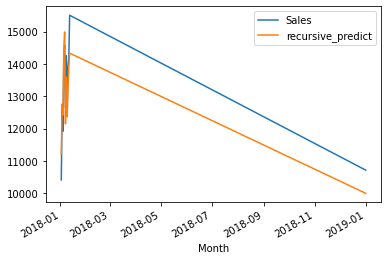

In [22]:
test.plot()

In [23]:
rmse = sqrt(mean_squared_error(test['Sales'], test['recursive_predict']))
print(rmse)

597.1250146220971


In [24]:
test

,Sales,recursive_predict
Month,,
2018-01-02,10415,11206.093895
2018-01-03,12683,12759.193459
2018-01-04,11919,12417.397218
2018-01-05,14138,14457.699783
2018-01-06,14583,14988.101575
2018-01-07,12640,12145.628810
2018-01-08,14257,13592.923891
2018-01-09,12396,12364.900268
2018-01-10,13914,13213.315838


# Direct Startegy

In [25]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [26]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [27]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.67290354], dtype=float32),
 array([0.66171396], dtype=float32),
 array([0.6776652], dtype=float32),
 array([0.69457626], dtype=float32),
 array([0.6832756], dtype=float32),
 array([0.68066096], dtype=float32),
 array([0.70005536], dtype=float32),
 array([0.7154181], dtype=float32),
 array([0.69601536], dtype=float32),
 array([0.7311272], dtype=float32),
 array([0.7170177], dtype=float32),
 array([0.71448857], dtype=float32)]

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

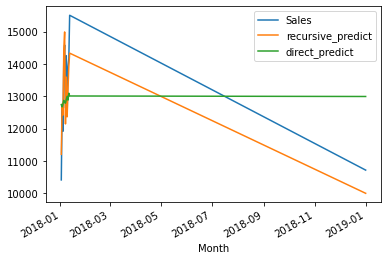

In [29]:
test.plot()

In [30]:
rmse = sqrt(mean_squared_error(test['Sales'], test['direct_predict']))
print(rmse)

1492.937023517013


In [31]:
test

,Sales,recursive_predict,direct_predict
Month,,,
2018-01-02,10415,11206.093895,12740.599317
2018-01-03,12683,12759.193459,12672.544291
2018-01-04,11919,12417.397218,12769.559588
2018-01-05,14138,14457.699783,12872.412834
2018-01-06,14583,14988.101575,12803.682080
2018-01-07,12640,12145.628810,12787.779977
2018-01-08,14257,13592.923891,12905.736704
2018-01-09,12396,12364.900268,12999.172886
2018-01-10,13914,13213.315838,12881.165407


# Direct Recursive Startegy

In [32]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [33]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [34]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.6488652], dtype=float32),
 array([0.67124504], dtype=float32),
 array([0.71515006], dtype=float32),
 array([0.71215725], dtype=float32),
 array([0.72445947], dtype=float32),
 array([0.7193991], dtype=float32),
 array([0.7469116], dtype=float32),
 array([0.75518274], dtype=float32),
 array([0.76593477], dtype=float32),
 array([0.7782363], dtype=float32),
 array([0.7818743], dtype=float32),
 array([0.7675353], dtype=float32)]

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Month'>

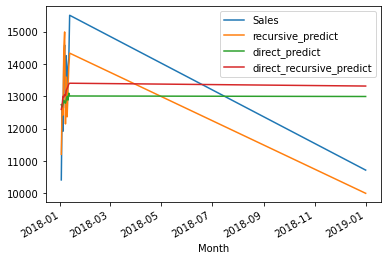

In [36]:
test.plot()

In [37]:
rmse = sqrt(mean_squared_error(test['Sales'], test['direct_recursive_predict']))
print(rmse)

1406.94239443875


In [38]:
test

,Sales,recursive_predict,direct_predict,direct_recursive_predict
Month,,,,
2018-01-02,10415,11206.093895,12740.599317,12594.398286
2018-01-03,12683,12759.193459,12672.544291,12730.512324
2018-01-04,11919,12417.397218,12769.559588,12997.542654
2018-01-05,14138,14457.699783,12872.412834,12979.340391
2018-01-06,14583,14988.101575,12803.682080,13054.162492
2018-01-07,12640,12145.628810,12787.779977,13023.385293
2018-01-08,14257,13592.923891,12905.736704,13190.716262
2018-01-09,12396,12364.900268,12999.172886,13241.021443
2018-01-10,13914,13213.315838,12881.165407,13306.415243


# MIMO

In [39]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [40]:
n_input = 12
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [41]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [42]:
model.fit(X, y, epochs=50, verbose=0)

In [43]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_25 (Dense)             (None, 12)                2412      
Total params: 164,012
Trainable params: 164,012
Non-trainable params: 0
_________________________________________________________________


In [44]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [45]:
res.shape

(12, 1)

In [46]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [47]:
test

,Sales,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
Month,,,,,
2018-01-02,10415,11206.093895,12740.599317,12594.398286,13023.342773
2018-01-03,12683,12759.193459,12672.544291,12730.512324,12650.346680
2018-01-04,11919,12417.397218,12769.559588,12997.542654,12761.875000
2018-01-05,14138,14457.699783,12872.412834,12979.340391,12855.994141
2018-01-06,14583,14988.101575,12803.682080,13054.162492,13046.873047
2018-01-07,12640,12145.628810,12787.779977,13023.385293,13275.227539
2018-01-08,14257,13592.923891,12905.736704,13190.716262,13169.182617
2018-01-09,12396,12364.900268,12999.172886,13241.021443,13229.004883
2018-01-10,13914,13213.315838,12881.165407,13306.415243,13207.970703


<AxesSubplot:xlabel='Month'>

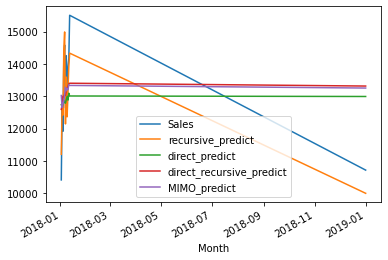

In [48]:
test.plot()

In [49]:
rmse = sqrt(mean_squared_error(test['Sales'], test['MIMO_predict']))
print(rmse)

1474.8944157144358


# Direct MIMO

In [62]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [63]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [64]:
n_input = 12
n_features = 1
test_predictions = []

n_output = 3

q = int(len(scaled_test)/n_output)

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.62647766, 0.6714652 , 0.734063  ]], dtype=float32),
 array([[0.653218  , 0.6655426 , 0.69547516]], dtype=float32),
 array([[0.71158355, 0.7309124 , 0.75517946]], dtype=float32),
 array([[0.7005771 , 0.67992806, 0.6931075 ]], dtype=float32)]

In [65]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [66]:
res = np.array(res)
res = res.reshape((res.shape[0],1))
res.shape

(12, 1)

In [67]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [68]:
test

,Sales,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
Month,,,,,,
2018-01-02,10415,11206.093895,12740.599317,12594.398286,13023.342773,12458.238281
2018-01-03,12683,12759.193459,12672.544291,12730.512324,12650.346680,12731.851562
2018-01-04,11919,12417.397218,12769.559588,12997.542654,12761.875000,13112.571289
2018-01-05,14138,14457.699783,12872.412834,12979.340391,12855.994141,12620.872070
2018-01-06,14583,14988.101575,12803.682080,13054.162492,13046.873047,12695.830078
2018-01-07,12640,12145.628810,12787.779977,13023.385293,13275.227539,12877.879883
2018-01-08,14257,13592.923891,12905.736704,13190.716262,13169.182617,12975.851562
2018-01-09,12396,12364.900268,12999.172886,13241.021443,13229.004883,13093.410156
2018-01-10,13914,13213.315838,12881.165407,13306.415243,13207.970703,13241.001953


<AxesSubplot:xlabel='Month'>

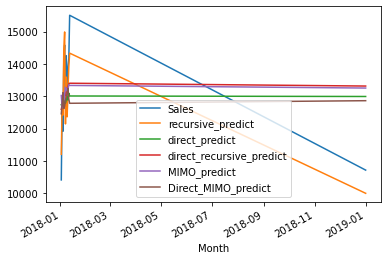

In [69]:
test.plot()

In [70]:
rmse = sqrt(mean_squared_error(test['Sales'], test['Direct_MIMO_predict']))
print(rmse)

1519.532852546507


In [71]:
rec_err = abs(test['Sales'] - test['recursive_predict'])
dir_err = abs(test['Sales'] - test['direct_predict'])
dir_rec_err = abs(test['Sales'] - test['direct_recursive_predict'])
mimo_err = abs(test['Sales'] - test['MIMO_predict'])
dir_mimo_err = abs(test['Sales'] - test['Direct_MIMO_predict'])

In [72]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [73]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
Month,,,,,
2018-01-02,791.093895,2325.599317,2179.398286,2608.342773,2043.238281
2018-01-03,76.193459,10.455709,47.512324,32.653320,48.851562
2018-01-04,498.397218,850.559588,1078.542654,842.875000,1193.571289
2018-01-05,319.699783,1265.587166,1158.659609,1282.005859,1517.127930
2018-01-06,405.101575,1779.317920,1528.837508,1536.126953,1887.169922
2018-01-07,494.371190,147.779977,383.385293,635.227539,237.879883
2018-01-08,664.076109,1351.263296,1066.283738,1087.817383,1281.148438
2018-01-09,31.099732,603.172886,845.021443,833.004883,697.410156
2018-01-10,700.684162,1032.834593,607.584757,706.029297,672.998047


<AxesSubplot:xlabel='Month'>

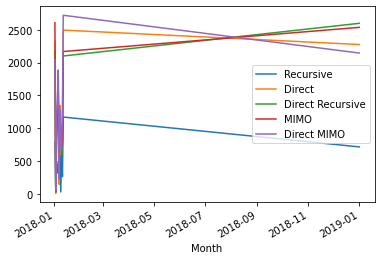

In [74]:
errors.plot()